In [74]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [76]:
dataset_path = "dataset_amyloid.pickle"
with open(dataset_path, 'rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)
max = np.max(X)
print(max)
# Change type of feature elements into float16
# Runtime warning: overflow; should change type after scaled
# X = X.astype(np.float16)
# X_train = X_train.astype(np.float16)
# X_test = X_test.astype(np.float16)

5347441.0


In [57]:
# print(X_train.shape)
# print(X_test.shape)
# print(X)
# print(Y)
# print(X.shape)
# X_df = pd.DataFrame(X)
# X_scaled = pd.DataFrame(X_scaled)
# Y_df = pd.DataFrame(Y)
# print(X_df)
# print(Y_df)
# print(X.dtype)
# print(Y.dtype)

In [58]:
# Normalizing Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.astype(np.float32)

X_tensor = torch.FloatTensor(X_scaled)

label_encoder = LabelEncoder()
Y_numerical = label_encoder.fit_transform(Y)

In [59]:
class Array_Encoder(nn.Module):
    def __init__(self, output_size, input_size):
        super(Array_Encoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, output_size),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.fc(x)

class Array_Decoder(nn.Module):
    def __init__(self, embedding_size, output_size):
        super(Array_Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(embedding_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        return self.fc(x)


In [87]:
# Defining Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = Array_Encoder(output_size=encoding_dim, input_size=input_size)
        self.decoder = Array_Decoder(embedding_size=encoding_dim, output_size=input_size)

    def encode(self, x):
        return self.encoder(x)

       # self.encoder = nn.Sequential(
       #      nn.Linear(input_dim, 1024),
       #      nn.ReLU(),
       #      nn.Linear(1024, 128),
       #      nn.ReLU(),
       #      nn.Linear(128, 64),
       #      nn.ReLU(),
       #      nn.Linear(64, encoding_dim)
       #  )

       #  self.decoder = nn.Sequential(
       #      nn.Linear(encoding_dim, 64),
       #      nn.ReLU(),
       #      nn.Linear(64, 128),
       #      nn.ReLU(),
       #      nn.Linear(128, 1024),
       #      nn.ReLU(),
       #      nn.Linear(1024, input_size)
       #  )
       
       # self.encoder = nn.Sequential(
       #     nn.Linear(input_size, 16),
       #     nn.ReLU(),
       #     nn.Linear(16, encoding_dim),
       #     nn.ReLU()
       # )
       # self.decoder = nn.Sequential(
       #     nn.Linear(encoding_dim, 16),
       #     nn.ReLU(),
       #     nn.Linear(16, input_size),
       #     # nn.Sigmoid()
       # )

    def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

In [88]:
# Setting random seed for reproducibility
torch.manual_seed(42)

input_size = X.shape[1]  # Number of input features
encoding_dim = 32  # Desired number of output dimensions
model = Autoencoder(input_size, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Training the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
   # Forward pass
   outputs = model(X_tensor)
   loss = criterion(outputs, X_tensor)


   # Backward pass and optimization
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

   # Loss for each epoch
   print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
# Encoding the data using the trained autoencoder
encoded_data = model.encode(X_tensor).detach().numpy()
# encoded_data = model.encoder(X_tensor).detach().numpy()
# encoded_tensor = torch.FloatTensor(encoded_data)
# decoded_data = model.decoder(encoded_tensor).detach().numpy()
outputs_np = outputs.detach().numpy()
# outputs_np = scaler.inverse_transform(outputs_data)

Epoch [1/20], Loss: 0.9494
Epoch [2/20], Loss: 1.0664
Epoch [3/20], Loss: 0.7976
Epoch [4/20], Loss: 0.7474
Epoch [5/20], Loss: 0.7258
Epoch [6/20], Loss: 0.7032
Epoch [7/20], Loss: 0.6781
Epoch [8/20], Loss: 0.6489
Epoch [9/20], Loss: 0.6202
Epoch [10/20], Loss: 0.5949
Epoch [11/20], Loss: 0.5749
Epoch [12/20], Loss: 0.5593
Epoch [13/20], Loss: 0.5457
Epoch [14/20], Loss: 0.5329
Epoch [15/20], Loss: 0.5201
Epoch [16/20], Loss: 0.5083
Epoch [17/20], Loss: 0.4980
Epoch [18/20], Loss: 0.4890
Epoch [19/20], Loss: 0.4801
Epoch [20/20], Loss: 0.4715


In [89]:
from sklearn.metrics import mean_squared_error

# mse = mean_squared_error(X_scaled.flatten(), decoded_data.flatten())
mse = mean_squared_error(X_scaled.flatten(), outputs_np.flatten())
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.47145652770996094


In [63]:
# print("Original training data dimensions:", X_train.shape)
# print("Original data dimensions:", X.shape)
# print("Reduced data dimensions:", encoded_data.shape)
# print("Reduced data:", encoded_data)
# print("Original data:", X)
# print("Decoded data:", decoded_data)

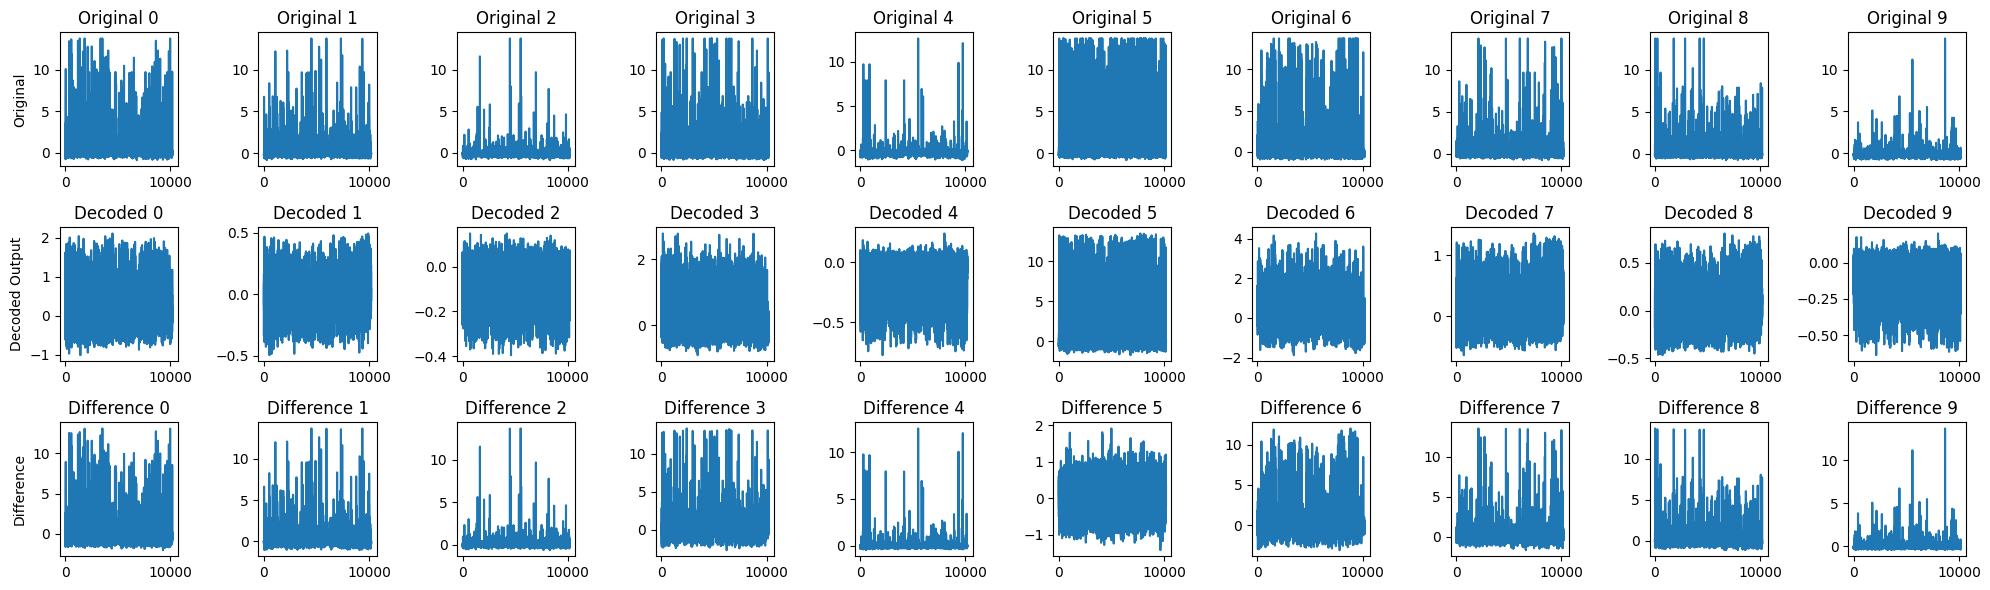

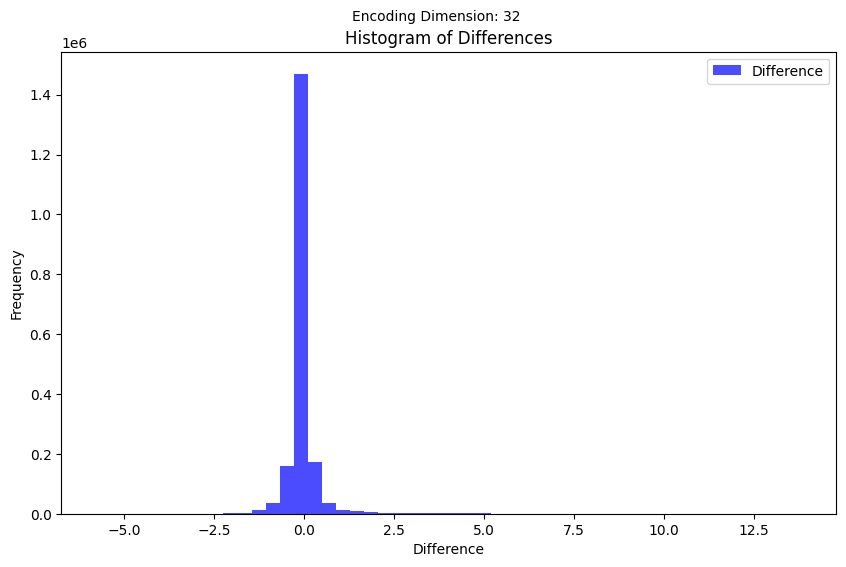

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `data_input` is the original dataset and `decoded_data_np` is the decoded dataset

# Compute the difference
# difference = X_scaled - decoded_data
difference = X_scaled - outputs_np
# Function to visualize the original vs decoded data and the difference
# def visualize_data(original, decoded, difference, encoded, num_samples=10):
#     fig, axes = plt.subplots(nrows=4, ncols=num_samples, figsize=(20, 6))
    
#     for i in range(num_samples):
#         # Original data
#         axes[0, i].plot(original[i])
#         axes[0, i].set_title(f'Original {i}')
        
#         # Decoded data
#         axes[1, i].plot(decoded[i])
#         axes[1, i].set_title(f'Decoded {i}')
        
#         # Difference
#         axes[2, i].plot(difference[i])
#         axes[2, i].set_title(f'Difference {i}')

#         # Encoded data
#         axes[3, i].plot(encoded[i])
#         axes[3, i].set_title(f'Encoded {i}')
    
#     axes[0, 0].set_ylabel('Original')
#     axes[1, 0].set_ylabel('Decoded')
#     axes[2, 0].set_ylabel('Difference')
#     axes[3, 0].set_ylabel('Encoded')
#     plt.tight_layout()
#     plt.savefig('Comparison_OriDeDifEncoded.png')
#     plt.show()

def visualize_data(original, output, difference, num_samples=10):
    fig, axes = plt.subplots(nrows=3, ncols=num_samples, figsize=(20, 6))
    
    for i in range(num_samples):
        # Original data
        axes[0, i].plot(original[i])
        axes[0, i].set_title(f'Original {i}')
        
        # Decoded data
        axes[1, i].plot(output[i])
        axes[1, i].set_title(f'Decoded {i}')
        
        # Difference
        axes[2, i].plot(difference[i])
        axes[2, i].set_title(f'Difference {i}')
    
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Decoded Output')
    axes[2, 0].set_ylabel('Difference')
    plt.tight_layout()
    plt.savefig('Comparison_OriDeDifEncoded.png')
    plt.show()
    
# Visualize
visualize_data(X_scaled, outputs_np, difference)

# Error histogram
plt.figure(figsize=(10, 6))
plt.hist(difference.flatten(), bins=50, color='blue', alpha=0.7, label='Difference')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.suptitle(f'Encoding Dimension: {encoding_dim}', fontsize=10, y=0.95)
plt.legend()
plt.savefig('Error_Histogram')
plt.show()


In [91]:
encoded_train = encoded_data[:155]
encoded_test = encoded_data[155:]

In [92]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(pd.__version__)
print(sklearn.__version__)

class MLP_model (nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_fc=nn.Linear(input_dim,5000)
        self.hidden_fc=nn.Linear(5000,4000)
        self.hidden_fc2=nn.Linear(4000,3000)
        self.hidden_fc9=nn.Linear(3000,2000)
        self.hidden_fc10=nn.Linear(2000,1000)
        self.hidden_fc11=nn.Linear(1000,500)
        self.hidden_fc12=nn.Linear(500,200)
        self.hidden_fc13=nn.Linear(200,50)


        self.output_fc=nn.Linear(50,output_dim)
        self.dropout = nn.Dropout(0.2)
        self.dropout_mid = nn.Dropout(0.05)
        self.dropout_small=nn.Dropout(0.05)

    def forward(self,x):
       batch_size=x.shape[0]
       x = x.view(batch_size, -1)
       x1=nn.functional.relu(self.input_fc(x))
       x1=self.dropout_mid(x1)
       x1=nn.functional.relu(self.hidden_fc(x1))
       x1=self.dropout_mid(x1)
       x1=nn.functional.relu(self.hidden_fc2(x1))
       x1=self.dropout_mid(x1)
       x1=nn.functional.relu(self.hidden_fc9(x1))
       x1=self.dropout_mid(x1)
       x1=nn.functional.relu(self.hidden_fc10(x1))
       x1=self.dropout_mid(x1)

       x1=nn.functional.relu(self.hidden_fc11(x1))
       x1=self.dropout_small(x1)
       x1=nn.functional.relu(self.hidden_fc12(x1))
       x1=self.dropout_small(x1)
       x1=nn.functional.relu(self.hidden_fc13(x1))
       x1=self.dropout_small(x1)
       #output=nn.functional.sigmoid(self.output_fc(x1))
       output=(self.output_fc(x1))

       return output 

def calculate_accuracy(y_pred, y):
  
    top_pred = y_pred.argmax(1)
    top_y= y.argmax(1)
    correct = top_pred.eq(top_y).sum()
    #print(top_pred)
    acc = correct.float() / y.shape[0]
    #print(correct)
    return acc

def model_train(model,dataloader,optimizer,citerion,device):
    epoch_loss=0
    epoch_acc=0
    model.train()

    for i,data in enumerate(dataloader):
        feature,label=data
        feature=feature.to(device)
        label=label.to(device)

        optimizer.zero_grad()
        y_pred=model(feature)
        loss=citerion(y_pred,label)
        acc=calculate_accuracy(y_pred,label)
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()
        epoch_acc+=acc.item()

    return epoch_loss/len(dataloader),epoch_acc/len(dataloader)


def model_evaluate(model,dataloader,criterion,device):
    epoch_loss=0
    epoch_acc=0

    model.eval()
    with torch.no_grad():
        for i,data in enumerate(dataloader):
            feature,label=data
            feature=feature.to(device)
            label=label.to(device)

            y_pred=model(feature)

            loss=criterion(y_pred,label)
            acc=calculate_accuracy(y_pred,label)

            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(dataloader),epoch_acc/len(dataloader)

class train_dataset(Dataset):
    def __init__(self,x_feature,y_label):
        self.x=x_feature
        self.y=y_label


    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        label=[0,0]
        if self.y[index]==1:
            label=[1,0]
        else:
            label=[0,1]
        
        feature=self.x[index]
        feature_tensor=torch.tensor(feature).float()
        label_tensor=torch.tensor(label).float()

        return feature_tensor,label_tensor

True
NVIDIA A100-SXM4-80GB
2.2.2
1.3.2


In [93]:
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f"Accuracy: {accuracy}")
# print(f"Classification Report:\n{report}")

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(encoded_train, y_train)

y_pred = model.predict(encoded_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.6857142857142857
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.91      0.78        22
           1       0.67      0.31      0.42        13

    accuracy                           0.69        35
   macro avg       0.68      0.61      0.60        35
weighted avg       0.68      0.69      0.65        35



In [95]:
X_train = encoded_train
X_test = encoded_test


input_dim=X_train.shape[1]

scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

model=MLP_model(input_dim,2) 


optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

# training_data=train_dataset(encoded_train,y_train)
# testing_data=train_dataset(encoded_test,y_test)
training_data=train_dataset(X_train,y_train)
testing_data=train_dataset(X_test,y_test)



training_dataloader=DataLoader(training_data,batch_size=32,shuffle=True)
testing_dataloader=DataLoader(testing_data,batch_size=32,shuffle=True)
EPOCHS=200

for epoch in range(EPOCHS):


    train_loss,train_acc=model_train(model,training_dataloader,optimizer,criterion,device)

    test_loss,test_acc=model_evaluate(model,testing_dataloader,criterion,device)
    print(f'\t E {epoch} Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t E {epoch} Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')



	 E 0 Train Loss: 0.684 | Train Acc: 54.98%
	 E 0 Test. Loss: 0.623 |  Test. Acc: 79.69%
	 E 1 Train Loss: 0.684 | Train Acc: 58.61%
	 E 1 Test. Loss: 0.717 |  Test. Acc: 49.48%
	 E 2 Train Loss: 0.681 | Train Acc: 58.03%
	 E 2 Test. Loss: 0.658 |  Test. Acc: 64.58%
	 E 3 Train Loss: 0.680 | Train Acc: 58.61%
	 E 3 Test. Loss: 0.663 |  Test. Acc: 64.58%
	 E 4 Train Loss: 0.678 | Train Acc: 59.19%
	 E 4 Test. Loss: 0.664 |  Test. Acc: 64.58%
	 E 5 Train Loss: 0.678 | Train Acc: 58.73%
	 E 5 Test. Loss: 0.661 |  Test. Acc: 64.58%
	 E 6 Train Loss: 0.678 | Train Acc: 58.96%
	 E 6 Test. Loss: 0.659 |  Test. Acc: 64.58%
	 E 7 Train Loss: 0.678 | Train Acc: 58.61%
	 E 7 Test. Loss: 0.605 |  Test. Acc: 79.69%
	 E 8 Train Loss: 0.678 | Train Acc: 58.84%
	 E 8 Test. Loss: 0.710 |  Test. Acc: 49.48%
	 E 9 Train Loss: 0.678 | Train Acc: 58.73%
	 E 9 Test. Loss: 0.658 |  Test. Acc: 64.58%
	 E 10 Train Loss: 0.678 | Train Acc: 58.61%
	 E 10 Test. Loss: 0.710 |  Test. Acc: 49.48%
	 E 11 Train Loss: 

In [ ]:
# from xgboost import XGBClassifier
# # precision_score, f1_score, 
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)
# y_pred = xgb.predict(X_test)
# print(f"Acc ori: {accuracy_score(y_test, y_pred)}")

In [ ]:
# NLP on encoded data: Acc 49~79